# Problem 1

In [36]:
import dolfin

import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [37]:
class FullyConnectedNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, activation_function=0):
        super(FullyConnectedNetwork, self).__init__()

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, 1)

        self.activation_function = [torch.nn.ReLU(), torch.nn.Tanh(), torch.nn.Sigmoid()][activation_function]

    def forward(self, x):
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        u_x = self.fc4(x)
        return u_x

In [94]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_ux = torch.autograd.grad(ux_omega.sum(), x_omega, create_graph=True)[0][:, 0]

        physical_term1 = grad_ux.abs().pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 0.5*physical_term1.mean()
        loss_term2 = physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class Omega2D(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train = self._create_points_for_training()
        self.mesh_eval = self._create_points_for_evaluation()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        return omega_coordinates, boundary_coordinates
    
    def _create_points_for_evaluation(self):
        mesh = dolfin.RectangleMesh(dolfin.Point(self.x_bounds[0], self.y_bounds[0]), dolfin.Point(self.x_bounds[1], self.y_bounds[1]), 100, 100)
        mesh_coordinates = mesh.coordinates()

        return np.array(mesh_coordinates)

    def plot(self):
        plt.scatter(self.omega_train[:, 0], self.omega_train[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_train[:, 0], self.boundary_train[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [65]:
class ExampleOne():
    def __init__(self, hidden_size, actv_func=1):
        
        self.model = FullyConnectedNetwork(2, hidden_size, actv_func)
        self.criterion = DeepRitzLoss()

        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

    def train(self, n_iter):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.model.train()

        for iter_i in range(n_iter):
            integration_grid = Omega2D(100, 75)

            x_omega = torch.FloatTensor(integration_grid.omega_train)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train)
            fx_omega = torch.FloatTensor(self.f(x_omega)).unsqueeze(1)
            cl_boundary = self.cl_boundary(x_boundary)

            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = (1-x1**2)*(1-x2**2)
        return fx

def asses_solution(example):
    model = example.model
    model.eval()

    evaluation_grid = Omega2D()
    x_eval = torch.FloatTensor(evaluation_grid.mesh_eval)

    u_pred = (model(x_eval).detach().numpy()).reshape(101, 101)
    u_exact = (example.f(x_eval).numpy()).reshape(101, 101)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axes[0].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[0].set_title('Predicted solution')
    fig.colorbar(im0, ax=axes[0], shrink=0.6)

    im1 = axes[1].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[1].set_title('Exact solution')
    fig.colorbar(im1, ax=axes[1], shrink=0.6)

    plt.show()

In [106]:
torch.manual_seed(15)

SyntaxError: invalid syntax (2213699567.py, line 2)

In [101]:
model1 = ExampleOne(hidden_size=20, actv_func=1)
model1.train(5000)

Iteration 0, loss: 5.716414451599121
Iteration 100, loss: 0.0010844188509508967
Iteration 200, loss: -0.0006658667698502541
Iteration 300, loss: -0.001410504337400198
Iteration 400, loss: -0.001596605870872736
Iteration 500, loss: -0.0013363936450332403
Iteration 600, loss: -0.0024284743703901768
Iteration 700, loss: -0.0014297873713076115
Iteration 800, loss: -0.002733515575528145
Iteration 900, loss: -0.002201722003519535
Iteration 1000, loss: -0.002063463209196925
Iteration 1100, loss: -0.0032388982363045216
Iteration 1200, loss: -0.0026540993712842464
Iteration 1300, loss: -0.003987670876085758
Iteration 1400, loss: -0.003984207287430763
Iteration 1500, loss: -0.0041020773351192474
Iteration 1600, loss: -0.005386959295719862
Iteration 1700, loss: -0.004975074902176857
Iteration 1800, loss: -0.00662588607519865
Iteration 1900, loss: -0.008059374056756496
Iteration 2000, loss: -0.009161679074168205
Iteration 2100, loss: -0.011785252019762993
Iteration 2200, loss: -0.01033408567309379

1.4222222222222223


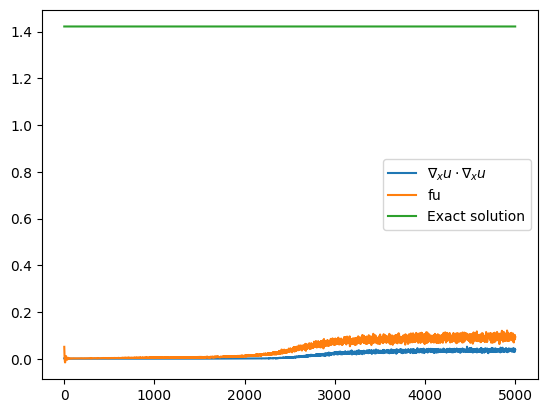

In [103]:
plt.plot(model1.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$')
plt.plot(model1.physical_loss2, label=r'fu')
plt.plot(np.ones(len(model1.physical_loss1))*64/45, label='Exact solution')
plt.legend()
print(64/45)

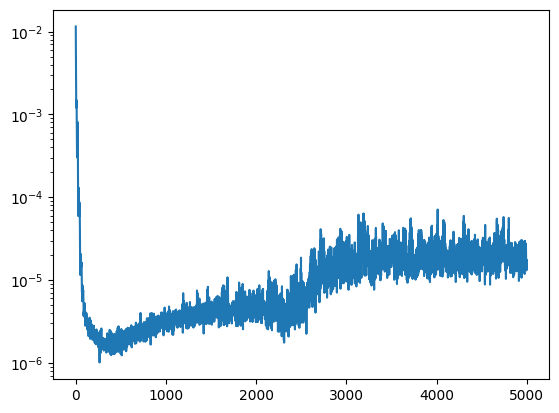

In [104]:
plt.plot(model1.boundary_loss, label=r'$(u - c_l)^2$')
plt.yscale('log')

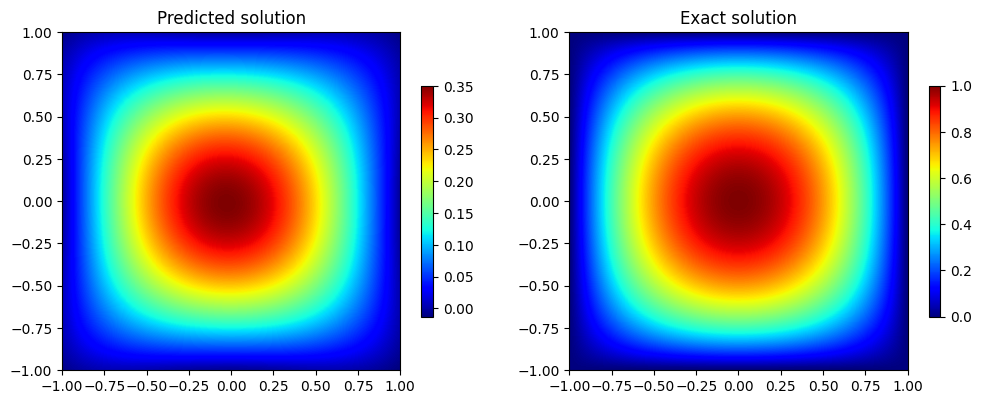

In [105]:
asses_solution(model1)